In [1]:
import pandas as pd
import numpy as np
from datetime import date

import pandas_datareader.data as web
import pandas_datareader as pdr

/Users/markhendricks/Projects/finm-portfolio-2023/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
START_DATE = '1999-01-01'
END_DATE = '2023-11-30'
TICKS_FX = ['DEXUSUK','DEXUSEU','DEXSZUS','DEXJPUS']
TICKS_RF = ['SOFR','IUDSOIA']
LABS_RF = ['SOFR','SONIA']
TICKS_CRYPTO = ['CBBTCUSD','CBETHUSD','CBLTCUSD','CBBCHUSD']
LABS = ['BTC','ETH','LTC','BCH']

INDIRECT = False

fxraw = pdr.DataReader(TICKS_FX,data_source='fred', start=START_DATE,end=END_DATE)

map_labels = {TICKS_RF[i]:LABS_RF[i] for i in range(len(TICKS_RF))}
rf = pdr.DataReader(TICKS_RF,data_source='fred', start=START_DATE,end=END_DATE).rename(columns=map_labels).dropna()/100

map_labels = {TICKS_CRYPTO[i]:LABS[i] for i in range(len(TICKS_CRYPTO))}
crypto = pdr.DataReader(TICKS_CRYPTO,data_source='fred', start=START_DATE,end=END_DATE).rename(columns=map_labels)

In [3]:
info = pd.DataFrame(columns=['Ticker Description'])

info.loc['USUK'] = 'Spot FX, US per UK (GBP)'
info.loc['USEU'] = 'Spot FX, US per EU (EUR)'
info.loc['USSZ'] = 'Spot FX, US per SZ (CHF)'
info.loc['USJPY'] = 'Spot FX, US per JP (JPY)'
info

,Ticker Description
USUK,"Spot FX, US per UK (GBP)"
USEU,"Spot FX, US per EU (EUR)"
USSZ,"Spot FX, US per SZ (CHF)"
USJPY,"Spot FX, US per JP (JPY)"


In [4]:
RESAMPLE = False
FREQ = 'D'
    
if FREQ == 'M':
    SCALE = 30
elif FREQ == 'Y':
    SCALE = ANNUALIZATION
elif FREQ == 'D':
    SCALE = 1
else:
    error('Frequency needs specified.')

In [5]:
fx = pd.DataFrame(index=fxraw.index)

for tick in TICKS_FX:
    lab = tick[-4:]
    if lab[-2:] == 'US':
        lab = lab[-2:] + lab[-4:-2]
        fx[lab] = 1/fxraw[tick]
    else:
        fx[lab] = fxraw[tick]

if RESAMPLE:
    fx = fx.resample(FREQ).last()
    
if INDIRECT:
    fx = 1/fx

In [6]:
fx, crypto = fx.dropna().align(crypto.dropna(),join='inner',axis=0)

<Axes: >

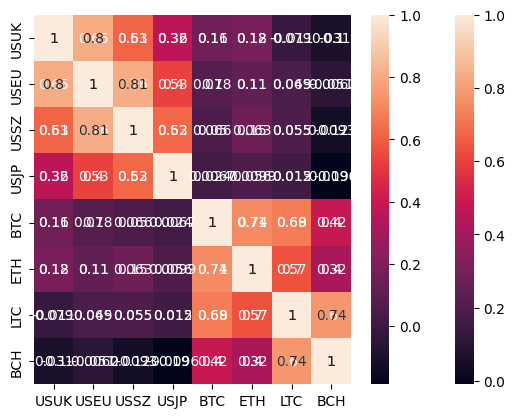

In [7]:
currency = pd.concat([fx,crypto],axis=1)

import seaborn as sns
sns.heatmap(currency.diff().corr(),annot=True)

sns.heatmap(currency.resample('M').last().diff().corr(),annot=True)

# Save to Excel

In [8]:
fx, rf = fx.align(rf,join='inner',axis=0)
fx, crypto = fx.align(crypto, join='inner',axis=0)

with pd.ExcelWriter('../fx_data.xlsx') as writer:  
    info.to_excel(writer, sheet_name = 'descriptions')
    fx.to_excel(writer, sheet_name='fx rates')
    rf.to_excel(writer, sheet_name='interest rates')
    crypto.to_excel(writer, sheet_name='crypto')